In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import splitfolders

In [3]:
splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Distance Based Traffic Alert System Using Deep Learning\dataset\Dataset2", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 100 files [00:00, 913.90 files/s]


In [4]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [5]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [6]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 3 images in output\test\0
0 folder and 3 images in output\test\1
2 folder and 0 images in output\train
0 folder and 33 images in output\train\0
0 folder and 42 images in output\train\1
2 folder and 0 images in output\val
0 folder and 8 images in output\val\0
0 folder and 11 images in output\val\1


In [7]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (224, 224, 3)


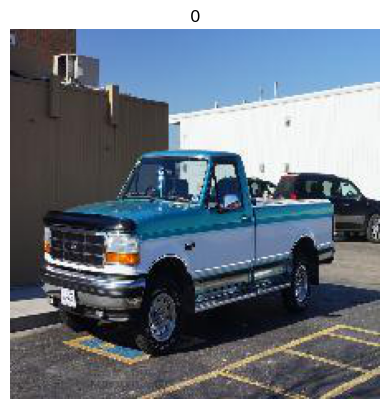

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='0')

Image Shape : (224, 224, 3)


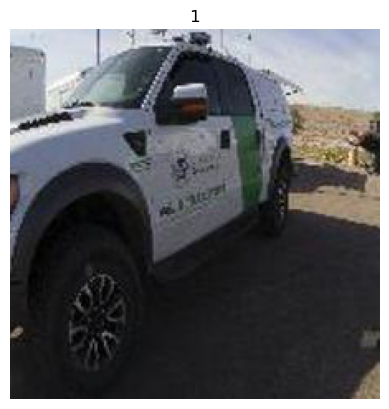

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='1')

In [10]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 75 images belonging to 2 classes.
Found 19 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [12]:
train_data.class_indices

{'0': 0, '1': 1}

In [13]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [14]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (75,)
val_y.shape:  (19,)
test_y.shape:  (6,)


In [15]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [16]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=20, validation_data=valid_data)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 8s/step - accuracy: 0.4501 - loss: 0.8319 - val_accuracy: 0.5263 - val_loss: 0.7188
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.3895 - loss: 0.7882 - val_accuracy: 0.7368 - val_loss: 0.6579
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6120 - loss: 0.6422 - val_accuracy: 0.7895 - val_loss: 0.6215
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7003 - loss: 0.6564 - val_accuracy: 0.8421 - val_loss: 0.5649
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6825 - loss: 0.5973 - val_accuracy: 0.8421 - val_loss: 0.5208
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.7669 - loss: 0.5703 - val_accuracy: 0.8421 - val_loss: 0.4851
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7515 - loss: 0.4852 - val_accuracy: 0.8421 - val_loss: 0.4528
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.7491 - loss: 0.5220 - val_accuracy: 0.8421 - val_loss: 0.4226
Epoch 9/20
2/2 

In [21]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

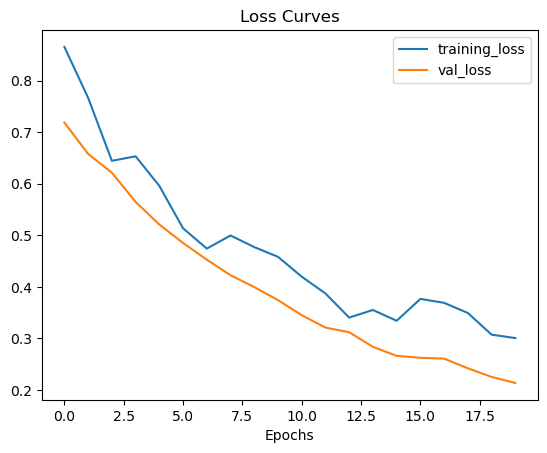

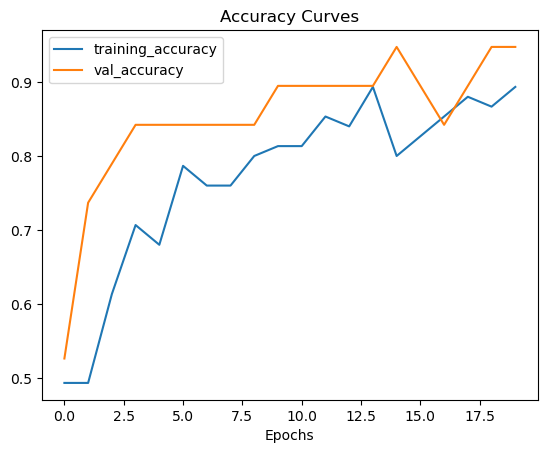

In [22]:
plot_loss_curves(history)

In [23]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.91      1.00      0.95        10

    accuracy                           0.95        19
   macro avg       0.95      0.94      0.95        19
weighted avg       0.95      0.95      0.95        19



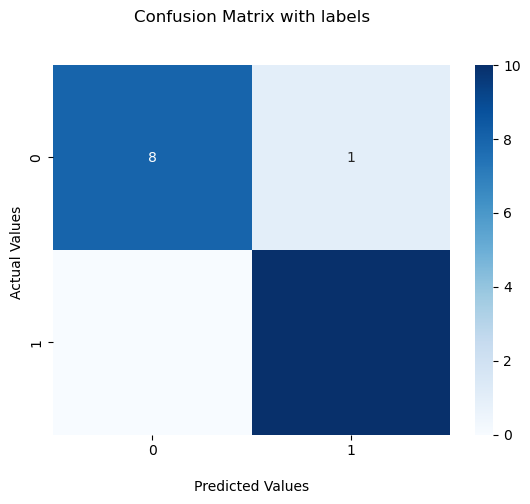

In [24]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



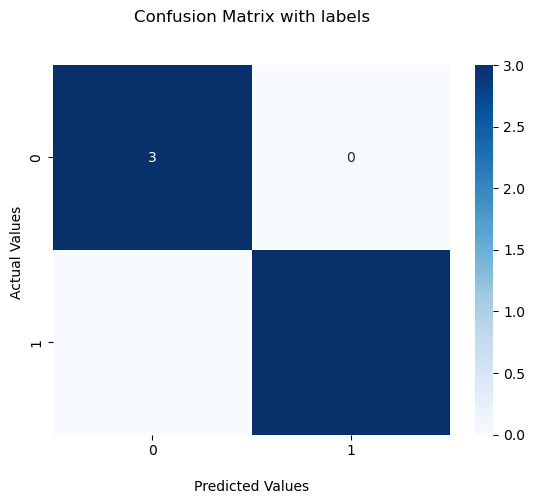

In [26]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [27]:
model.save('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Normal


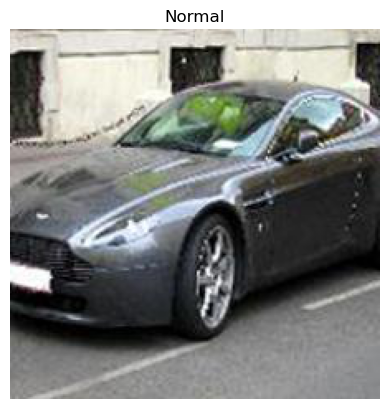

In [30]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Distance Based Traffic Alert System Using Deep Learning\dataset\Dataset2\0\0_original_1231.jpg_83b671ae-3bea-4cd1-a283-138ebd5a2e49.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Normal', 'Emergency Vechicle']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Emergency Vechicle


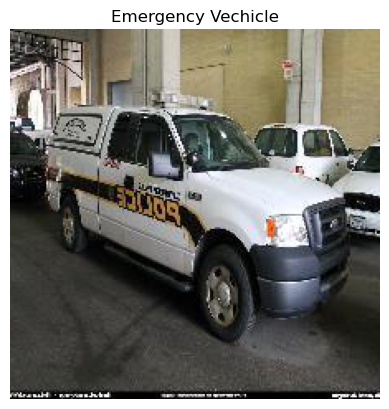

In [31]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Distance Based Traffic Alert System Using Deep Learning\dataset\Dataset2\1\1_original_133.jpg_b5703006-2cb1-4f4a-8ebe-f62744b0d906.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Normal', 'Emergency Vechicle']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
